


# Dilated CNN model

In this notebook, we demonstrate how to:
* prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
* get data in the required shape for the keras API
* implement a CNN model in keras to predict the next step ahead (time t+1) in the time series
* enable early stopping to reduce the likelihood of model overfitting evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

C:\Users\Taillandy Valentin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [71]:
# Utilisation de Bokeh comme backend pour les plots pandas. 
# C'est mon choix, vous faites comme vous voulez
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
warnings.filterwarnings("ignore")

Load data into Pandas dataframe

In [4]:
eau_ESIEE = pd.read_csv("Eau_ESIEE_df.csv")
eau_ESIEE

Unnamed: 0     m3 E/M
0     2019-11-01  31.46   E
1     2019-11-02  21.76   E
2     2019-11-03  18.02   E
3     2019-11-04  29.98   E
4     2019-11-05  28.59   E
...          ...    ...  ..
1041  2022-09-09  16.08   M
1042  2022-09-10  18.25   M
1043  2022-09-11  31.56   M
1044  2022-09-12  26.90   M
1045  2022-09-13  29.65   M

[1046 rows x 3 columns]

In [5]:
eau_ESIEE.dropna(inplace=True)
eau_ESIEE.rename(columns={"Unnamed: 0": "date"},inplace=True)
eau_ESIEE["date"]= pd.to_datetime(eau_ESIEE["date"],format="%Y-%m-%d")
eau_ESIEE.set_index("date", inplace=True)

In [14]:
eau_ESIEE.plot()

Figure(id='1185', ...)

In [15]:
eau_ESIEE

m3 E/M
2019-11-01  31.46   E
2019-11-02  21.76   E
2019-11-03  18.02   E
2019-11-04  29.98   E
2019-11-05  28.59   E
...           ...  ..
2022-09-09  16.08   M
2022-09-10  18.25   M
2022-09-11  31.56   M
2022-09-12  26.90   M
2022-09-13  29.65   M

[1048 rows x 2 columns]

In [17]:
range_date = pd.date_range(start=eau_ESIEE.index.min(), end=eau_ESIEE.index.max())
eau_ESIEE=eau_ESIEE.reindex(range_date)
eau_ESIEE['m3_ma']=eau_ESIEE['m3'].rolling(5,min_periods=2).mean()
eau_ESIEE['m3'].fillna(eau_ESIEE['m3_ma'],inplace=True)
eau_ESIEE.drop(['m3_ma'],axis=1,inplace=True)
test = eau_ESIEE.reindex(pd.date_range('2019-11-01', '2022-09-13')).isnull().all(1)
test[test == True]

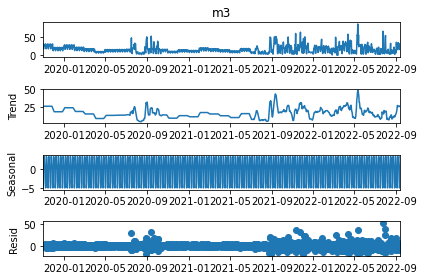

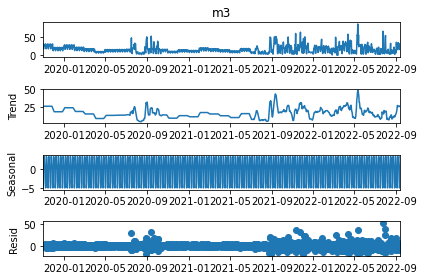

In [20]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(eau_ESIEE['m3'])
out.plot()

In [21]:
valid_start_dt = '2022-01-01'
test_start_dt = '2022-04-01'

In [22]:
eau_ESIEE[eau_ESIEE.index < valid_start_dt][['m3']].rename(columns={'m3':'train'}) \
    .join(eau_ESIEE[(eau_ESIEE.index >=valid_start_dt) & (eau_ESIEE.index < test_start_dt)][['m3']] \
          .rename(columns={'m3':'validation'}), how='outer') \
    .join(eau_ESIEE[test_start_dt:][['m3']].rename(columns={'m3':'test'}), how='outer')\
    .plot(y=['train', 'validation', 'test'])


Figure(id='1367', ...)

In [23]:
T = 10
HORIZON = 1

## PREPARE TRAIN DATA

In [24]:
train = eau_ESIEE.copy()[eau_ESIEE.index < valid_start_dt][['m3']]
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()
train['m3'] = scaler.fit_transform(train)
train.head(10)

m3
2019-11-01  0.476362
2019-11-02  0.317137
2019-11-03  0.255745
2019-11-04  0.452068
2019-11-05  0.429251
2019-11-06  0.370978
2019-11-07  0.397242
2019-11-08  0.476362
2019-11-09  0.317137
2019-11-10  0.255745

In [26]:
eau_ESIEE[eau_ESIEE.index < valid_start_dt][['m3']].rename(columns={'m3':'original m3'}).plot.hist(bins=100)
train.rename(columns={'m3':'scaled m3'}).plot.hist(bins=100)
plt.show()

In [27]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['m3'].shift(-1, freq='D')
train_shifted.head(10)

m3     y_t+1
2019-11-01  0.476362  0.317137
2019-11-02  0.317137  0.255745
2019-11-03  0.255745  0.452068
2019-11-04  0.452068  0.429251
2019-11-05  0.429251  0.370978
2019-11-06  0.370978  0.397242
2019-11-07  0.397242  0.476362
2019-11-08  0.476362  0.317137
2019-11-09  0.317137  0.255745
2019-11-10  0.255745  0.452068

In [28]:
for t in range(1, T+1):
    train_shifted['m3_t-'+str(T-t)] = train_shifted['m3'].shift(T-t, freq='D')
train_shifted = train_shifted.rename(columns={'m3':'m3_original'})
train_shifted.head(10)

m3_original     y_t+1    m3_t-9    m3_t-8    m3_t-7    m3_t-6  \
2019-11-01     0.476362  0.317137       NaN       NaN       NaN       NaN   
2019-11-02     0.317137  0.255745       NaN       NaN       NaN       NaN   
2019-11-03     0.255745  0.452068       NaN       NaN       NaN       NaN   
2019-11-04     0.452068  0.429251       NaN       NaN       NaN       NaN   
2019-11-05     0.429251  0.370978       NaN       NaN       NaN       NaN   
2019-11-06     0.370978  0.397242       NaN       NaN       NaN       NaN   
2019-11-07     0.397242  0.476362       NaN       NaN       NaN  0.476362   
2019-11-08     0.476362  0.317137       NaN       NaN  0.476362  0.317137   
2019-11-09     0.317137  0.255745       NaN  0.476362  0.317137  0.255745   
2019-11-10     0.255745  0.452068  0.476362  0.317137  0.255745  0.452068   

              m3_t-5    m3_t-4    m3_t-3    m3_t-2    m3_t-1    m3_t-0  
2019-11-01       NaN       NaN       NaN       NaN       NaN  0.476362  
2019-11-02       NaN       NaN       NaN       NaN  0.476362  0.317137  
2019-11-03       NaN       NaN       NaN  0.476362  0.317137  0.255745  
2019-11-04       NaN       NaN  0.476362  0.317137  0.255745  0.452068  
2019-11-05       NaN  0.476362  0.317137  0.255745  0.452068  0.429251  
2019-11-06  0.476362  0.317137  0.255745  0.452068  0.429251  0.370978  
2019-11-07  0.317137  0.255745  0.452068  0.429251  0.370978  0.397242  
2019-11-08  0.255745  0.452068  0.429251  0.370978  0.397242  0.476362  
2019-11-09  0.452068  0.429251  0.370978  0.397242  0.476362  0.317137  
2019-11-10  0.429251  0.370978  0.397242  0.476362  0.317137  0.255745

In [29]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

m3_original     y_t+1    m3_t-9    m3_t-8    m3_t-7    m3_t-6  \
2019-11-10     0.255745  0.452068  0.476362  0.317137  0.255745  0.452068   
2019-11-11     0.452068  0.429251  0.317137  0.255745  0.452068  0.429251   
2019-11-12     0.429251  0.370978  0.255745  0.452068  0.429251  0.370978   
2019-11-13     0.370978  0.397242  0.452068  0.429251  0.370978  0.397242   
2019-11-14     0.397242  0.476362  0.429251  0.370978  0.397242  0.476362   

              m3_t-5    m3_t-4    m3_t-3    m3_t-2    m3_t-1    m3_t-0  
2019-11-10  0.429251  0.370978  0.397242  0.476362  0.317137  0.255745  
2019-11-11  0.370978  0.397242  0.476362  0.317137  0.255745  0.452068  
2019-11-12  0.397242  0.476362  0.317137  0.255745  0.452068  0.429251  
2019-11-13  0.476362  0.317137  0.255745  0.452068  0.429251  0.370978  
2019-11-14  0.317137  0.255745  0.452068  0.429251  0.370978  0.397242

In [30]:
y_train = train_shifted[['y_t+1']].to_numpy()

In [31]:
X_train = train_shifted[['m3_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

## PREPARE VALIDATION DATA

In [32]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = eau_ESIEE.copy()[(eau_ESIEE.index >=look_back_dt) & (eau_ESIEE.index < test_start_dt)][['m3']]
valid.head()

m3
2021-12-23  8.31
2021-12-24  6.90
2021-12-25  8.38
2021-12-26  8.34
2021-12-27  8.79

In [33]:
valid['m3'] = scaler.transform(valid)
valid.head()

m3
2021-12-23  0.096356
2021-12-24  0.073211
2021-12-25  0.097505
2021-12-26  0.096848
2021-12-27  0.104235

In [34]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['m3'].shift(-1, freq='D')
for t in range(1, T+1):
    valid_shifted['m3_t-'+str(T-t)] = valid_shifted['m3'].shift(T-t, freq='D')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['m3_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [35]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
LATENT_DIM = 5 # Nombre de filtres
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 200

In [37]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 5)             15        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 5)             55        
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 5)             55        
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='Adam', loss='mse')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [39]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/200
25/25 [==============================] - 1s 16ms/step - loss: 0.0554 - val_loss: 0.0627
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0277
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0236
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0239
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0239
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0237
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0235
Epoch 8/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0226
Epoch 9/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0229
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0220
Epoch 11

In [40]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

In [41]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = eau_ESIEE.copy()[test_start_dt:][['m3']]
test.head()

m3
2022-04-01  14.78
2022-04-02  12.35
2022-04-03  31.46
2022-04-04  27.80
2022-04-05  37.38

In [42]:
test['m3'] = scaler.transform(test)
test.head()

m3
2022-04-01  0.202561
2022-04-02  0.162672
2022-04-03  0.476362
2022-04-04  0.416284
2022-04-05  0.573539

In [43]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['m3'].shift(-1, freq='D')
for t in range(1, T+1):
    test_shifted['m3_t'+str(T-t)] = test_shifted['m3'].shift(T-t, freq='D')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['m3_t'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

In [44]:
predictions = model.predict(X_test)
predictions

array([[ 0.3459562 ],
       [ 0.45460996],
       [ 0.6041414 ],
       [ 0.4745506 ],
       [ 0.2883349 ],
       [ 0.13239703],
       [ 0.2954585 ],
       [ 0.2555005 ],
       [ 0.43823406],
       [ 0.45745385],
       [ 0.42667738],
       [ 0.33674577],
       [ 0.36367092],
       [ 0.17244604],
       [ 0.35754645],
       [ 0.30372795],
       [ 0.14240858],
       [ 0.26238748],
       [ 0.2554598 ],
       [-0.00530571],
       [ 0.12175731],
       [ 0.16795191],
       [ 0.2098884 ],
       [ 0.19193792],
       [ 0.13878964],
       [ 0.10747293],
       [ 0.09130466],
       [ 0.12583648],
       [ 0.37372756],
       [ 0.5611268 ],
       [ 0.5689518 ],
       [ 0.89762723],
       [ 0.4205336 ],
       [ 0.51535386],
       [ 0.54223746],
       [ 0.5346916 ],
       [ 0.42859447],
       [ 0.5026666 ],
       [ 0.17373326],
       [ 0.5254468 ],
       [ 0.1417541 ],
       [ 0.15888634],
       [ 0.3503232 ],
       [ 0.3717062 ],
       [ 0.33816537],
       [ 0

In [45]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction  actual
0 2022-04-10  t+1   23.515652   33.50
1 2022-04-11  t+1   30.134839   57.89
2 2022-04-12  t+1   39.244295   30.93
3 2022-04-13  t+1   31.349623   25.49
4 2022-04-14  t+1   20.005362    6.72

In [46]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [47]:
MAPE(eval_df['prediction'], eval_df['actual'])

72.9666354238002

In [48]:
eval_df

timestamp    h  prediction  actual
0   2022-04-10  t+1   23.515652   33.50
1   2022-04-11  t+1   30.134839   57.89
2   2022-04-12  t+1   39.244295   30.93
3   2022-04-13  t+1   31.349623   25.49
4   2022-04-14  t+1   20.005362    6.72
..         ...  ...         ...     ...
151 2022-09-08  t+1   17.501445   16.08
152 2022-09-09  t+1   15.704103   18.25
153 2022-09-10  t+1   21.350676   31.56
154 2022-09-11  t+1   24.146798   26.90
155 2022-09-12  t+1   27.312676   29.65

[156 rows x 4 columns]

In [52]:
eval_df["timestamp"]= pd.to_datetime(eval_df["timestamp"],format="%Y-%m-%d")
eval_df.set_index("timestamp", inplace=True)

In [53]:
eval_df.plot()

Figure(id='2357', ...)

In [62]:
eval_df[eval_df.index<'2022-09-12'].plot(x=eval_df.index, y=['prediction', 'actual'])

Figure(id='3764', ...)

In [74]:
from sklearn.metrics import mean_absolute_error

In [76]:
mean_absolute_error(eval_df['prediction'], eval_df['actual'])

8.888346934927007

In [63]:
for m in glob('model_*.h5'):
    os.remove(m)


# ELEC

In [95]:
elec_ESIEE = pd.read_csv("Elec_ESIEE_df.csv")
elec_ESIEE

datetime     kW   kVAr   V
0       2016-02-01 00:00:00  504.0  234.0 NaN
1       2016-02-01 00:10:00  606.0  304.0 NaN
2       2016-02-01 00:20:00  555.0  257.0 NaN
3       2016-02-01 00:30:00  519.0  225.0 NaN
4       2016-02-01 00:40:00  518.0  225.0 NaN
...                     ...    ...    ...  ..
337920  2022-07-05 23:10:00  272.0    NaN NaN
337921  2022-07-05 23:20:00  279.0    NaN NaN
337922  2022-07-05 23:30:00  292.0    NaN NaN
337923  2022-07-05 23:40:00  273.0    NaN NaN
337924  2022-07-05 23:50:00  280.0    NaN NaN

[337925 rows x 4 columns]

In [96]:
elec_ESIEE.dropna(inplace=True)
elec_ESIEE["datetime"]= pd.to_datetime(elec_ESIEE["datetime"],format="%Y-%m-%d %H:%M:%S")
elec_ESIEE.set_index("datetime", inplace=True)
elec_ESIEE = elec_ESIEE.drop(["kVAr","V"],axis=1)
elec_ESIEE.plot()

Figure(id='4622', ...)

In [105]:
range_date = pd.date_range(start=elec_ESIEE.index.min(), end=elec_ESIEE.index.max())
elec_ESIEE=elec_ESIEE.reindex(range_date)
elec_ESIEE['kW_ma']=elec_ESIEE['kW'].rolling(102,min_periods=2).mean()
elec_ESIEE['kW'].fillna(elec_ESIEE['kW_ma'],inplace=True)
elec_ESIEE.drop(['kW_ma'],axis=1,inplace=True)
test = elec_ESIEE.reindex(range_date).isnull().all(1)
test[test == True]

Series([], Freq: D, dtype: bool)

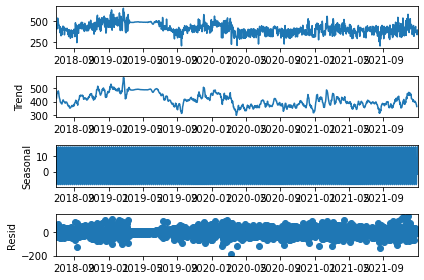

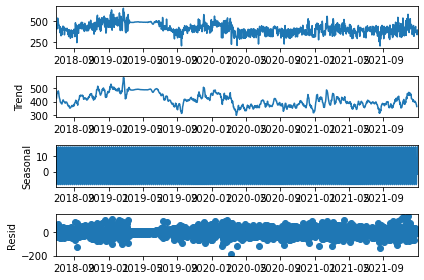

In [106]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(elec_ESIEE)
out.plot()

# GAZ

In [6]:
gaz_ESIEE = pd.read_csv("GAZ_ESIEE_df.csv")
gaz_ESIEE

Unnamed: 0     m3    Nm3     kWh E/M
0     2017-10-15  265.0  326.0  3736.0   E
1     2017-10-16  265.0  326.0  3736.0   E
2     2017-10-17  265.0  326.0  3736.0   E
3     2017-10-18  265.0  326.0  3736.0   E
4     2017-10-19  265.0  326.0  3736.0   E
...          ...    ...    ...     ...  ..
1672  2022-05-20  253.0  311.0  3579.0   M
1673  2022-05-21  240.0  295.0  3395.0   M
1674  2022-05-22  226.0  278.0  3197.0   M
1675  2022-05-23  255.0  313.0  3607.0   M
1676  2022-05-24  155.0  190.0  2193.0   M

[1677 rows x 5 columns]

In [7]:
energy.dropna(inplace=True)
#energy = energy[~(energy == "ND").any(axis=1)]
energy['nocha4'].replace("ND",None,inplace=True)
energy['nocha4'].replace("<2",2,inplace=True)
#energy = energy[~(energy == "<5").any(axis=1)]
#energy = energy[~(energy == ">1000").any(axis=1)]

energy["dateheure"]= pd.to_datetime(energy["dateheure"],format="%Y-%m-%d %H:%M:%S%z")
energy['dateheure'] = energy['dateheure'].apply(lambda x: x.replace(tzinfo=None))
energy.set_index("dateheure", inplace=True)

NameError: name 'energy' is not defined

In [7]:
energy[(energy == "<2").any(axis=1)]

nocha4 n2cha4 10cha4 c2cha4 tcha4 hycha4
dateheure                                                   
2022-09-26 07:00:00      7     <2     ND    425  19,6   47,5
2022-09-25 07:00:00      2     <2      6    425  18,2   56,7
2022-09-18 20:00:00   None     <2     12    466  19,4   37,7
2022-09-09 07:00:00      3     <2     ND    400  21,2   61,9

In [8]:
energy['nocha4'] = energy["nocha4"].astype(float)
#energy['n2cha4'] = energy["n2cha4"].astype(float)
#energy['10cha4'] = energy["10cha4"].astype(float)
#energy['c2cha4'] = energy["c2cha4"].astype(float)
#energy['tcha4'] = energy["tcha4"].astype(float)
#energy['hycha4'] = energy["hycha4"].astype(float)



In [9]:
test = energy['nocha4']
test

dateheure
2022-10-03 02:00:00    NaN
2022-10-03 01:00:00    NaN
2022-10-03 00:00:00    NaN
2022-10-02 23:00:00    NaN
2022-10-02 22:00:00    NaN
                      ... 
2013-01-01 06:00:00    4.0
2013-01-01 05:00:00    3.0
2013-01-01 04:00:00    4.0
2013-01-01 03:00:00    6.0
2013-01-01 02:00:00    6.0
Name: nocha4, Length: 60565, dtype: float64

In [10]:
energy['test'] = energy['nocha4'].interpolate(option='spline')

In [87]:
energy['test'].plot()

KeyError: 'test'

In [14]:
energy.columns

Index(['nocha4', 'n2cha4', '10cha4', 'c2cha4', 'tcha4', 'hycha4', 'test'], dtype='object')

In [15]:
energy = pd.read_csv("Rainfall_data.csv")
energy

Year  Month  Day  Specific Humidity  Relative Humidity  Temperature  \
0    2000      1    1               8.06              48.25        23.93   
1    2000      2    1               8.73              50.81        25.83   
2    2000      3    1               8.48              42.88        26.68   
3    2000      4    1              13.79              55.69        22.49   
4    2000      5    1              17.40              70.88        19.07   
..    ...    ...  ...                ...                ...          ...   
247  2020      8    1              20.08              92.31         5.34   
248  2020      9    1              19.71              90.12         9.22   
249  2020     10    1              18.43              82.69        12.62   
250  2020     11    1              14.83              76.06        16.95   
251  2020     12    1              12.21              69.38        17.77   

     Precipitation  
0             0.00  
1             0.11  
2             0.01  
3             0.02  
4           271.14  
..             ...  
247        1203.09  
248         361.30  
249         180.18  
250           0.49  
251          12.23  

[252 rows x 7 columns]

In [16]:
energy[["Year", "Month" , "Day"]] =  energy[["Year", "Month" , "Day"]].astype(str) 
energy['date'] = energy['Year'] + "-" + energy['Month'] + "-" + energy['Day']
energy.drop(["Year", "Month" , "Day"],axis=1,inplace=True)

In [17]:
energy["date"]= pd.to_datetime(energy["date"],format="%Y-%m-%d")
energy.set_index("date", inplace=True)

In [18]:
energy['Relative Humidity'].plot()

Figure(id='1697', ...)

In [19]:
energy = pd.read_csv("coffee.csv")
energy["Date"]= pd.to_datetime(energy["Date"],format="%Y-%m-%d")
energy.set_index("Date", inplace=True)
coffee = energy[["Open"]].copy()
coffee

Open
Date              
2000-01-03  122.25
2000-01-04  116.25
2000-01-05  115.00
2000-01-06  119.00
2000-01-07  117.25
...            ...
2022-08-29  240.55
2022-08-30  238.75
2022-08-31  240.75
2022-09-01  238.55
2022-09-02  232.50

[5746 rows x 1 columns]

In [20]:
coffee.plot()

Figure(id='1940', ...)

#Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [24]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(coffee)
#ou
res = STL(coffee).fit()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [62]:
energy = pd.read_csv("cinemaTicket_Ref.csv")
energy["date"]= pd.to_datetime(energy["date"],format="%Y-%m-%d")
#energy.set_index("date", inplace=True)
#ticket = energy.groupby(energy.index).sum()
#ticket = ticket['tickets_sold'].copy()
#ticket.plot()

In [63]:
ticket = energy.resample('D', on='date').sum().copy()
tickets_sold #= ticket['tickets_sold'].copy()
tickets_sold.plot()

Figure(id='5396', ...)

In [72]:
ticket['day_week']=ticket.index.dayofweek
tickets_sold = ticket[['tickets_sold','day_week']]

In [85]:
tickets_sold['tickets_sold'].plot()

Figure(id='9064', ...)

In [84]:
tickets_sold_day = ticket.groupby(ticket['day_week']).sum()
tickets_sold_day[['ticket_use','tickets_sold']].plot()

Figure(id='8588', ...)

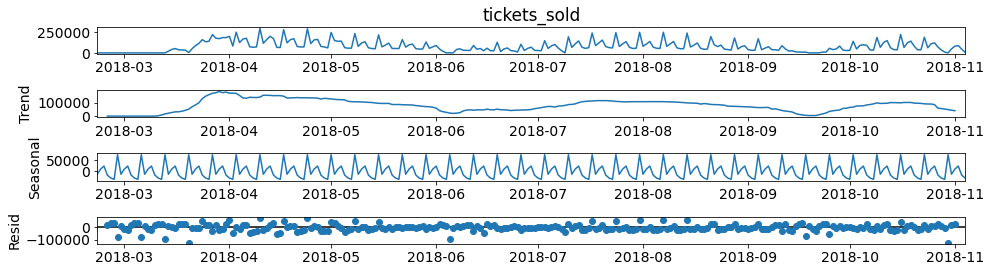

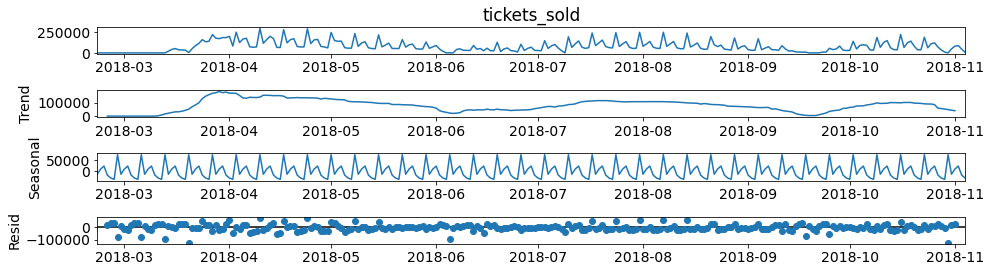

In [86]:
out = seasonal_decompose(tickets_sold['tickets_sold'])
out.plot()

#Data preparation - Training set

For this example, we will set T=10. This means that the input for each sample is a vector of the prevous 10 hours of the energy load. The choice of T=10 was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)

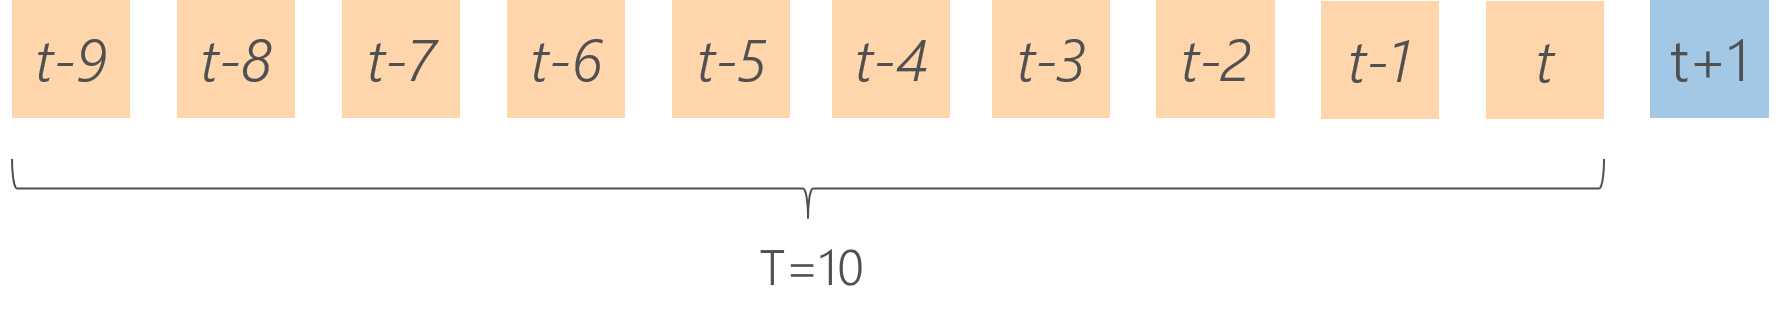

In [17]:
T = 10
HORIZON = 1

Our data preparation for the training set will involve the following steps:
1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras


# 1. Filter the original dataset to include only that time period reserved for the training set
Create training set containing only the model features

In [ ]:
train = # 

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
...                      ...
2014-08-31 19:00:00 3,969.00
2014-08-31 20:00:00 3,869.00
2014-08-31 21:00:00 3,643.00
2014-08-31 22:00:00 3,365.00
2014-08-31 23:00:00 3,097.00

[23376 rows x 1 columns]

# 2. Scale the time series such that the values fall within the interval (0, 1)

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = #
train['load'] = #
train.head(10)

load
2012-01-01 00:00:00  0.22
2012-01-01 01:00:00  0.18
2012-01-01 02:00:00  0.14
2012-01-01 03:00:00  0.13
2012-01-01 04:00:00  0.13
2012-01-01 05:00:00  0.15
2012-01-01 06:00:00  0.18
2012-01-01 07:00:00  0.23
2012-01-01 08:00:00  0.29
2012-01-01 09:00:00  0.35

Let us have a look at the original data with respect to the scaled data

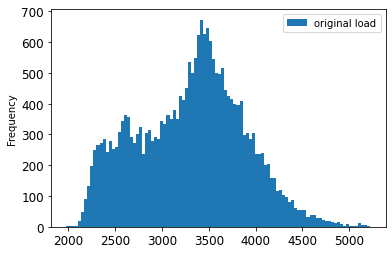

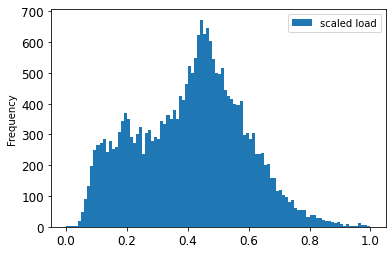

In [ ]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

# 3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
First, we create the target (y_t+1) variable. If we use the convention that the dataframe is indexed on time t, we need to shift the load variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

Hint: look at the shift method from pandas

In [ ]:
train_shifted = train.copy()
train_shifted['y_t+1'] = #
train_shifted.head(10)

load  y_t+1
2012-01-01 00:00:00  0.22   0.18
2012-01-01 01:00:00  0.18   0.14
2012-01-01 02:00:00  0.14   0.13
2012-01-01 03:00:00  0.13   0.13
2012-01-01 04:00:00  0.13   0.15
2012-01-01 05:00:00  0.15   0.18
2012-01-01 06:00:00  0.18   0.23
2012-01-01 07:00:00  0.23   0.29
2012-01-01 08:00:00  0.29   0.35
2012-01-01 09:00:00  0.35   0.37

We also need to shift the load variable back 10 times to create the input sequence:

Hint: do a loop

In [ ]:
# Code goes here
# ...
#
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

# 4. Discard any samples with missing values
Notice how we have missing values for the input sequences for the first 5 samples. We will discard these

In [ ]:
train_shifted = #
train_shifted.head(5)

load_original  y_t+1  ...  load_t-1  load_t-0
2012-01-01 09:00:00           0.35   0.37  ...      0.29      0.35
2012-01-01 10:00:00           0.37   0.37  ...      0.35      0.37
2012-01-01 11:00:00           0.37   0.37  ...      0.37      0.37
2012-01-01 12:00:00           0.37   0.36  ...      0.37      0.37
2012-01-01 13:00:00           0.36   0.35  ...      0.37      0.36

[5 rows x 12 columns]

# 5. Transform into a numpy arrays of shapes (samples, time steps, features) and (samples,1) for input into Keras
Now convert the target variable into a numpy array.

Hint: use to_numpy from pandas.

In [ ]:
y_train = #

We now have a vector for target variable of shape: 

In [ ]:
y_train.shape

(23366, 1)

The target variable for the first 3 samples looks like:

In [ ]:
y_train[:3]

array([[0.37],
       [0.37],
       [0.37]])

Now convert the inputs into a numpy array with shape (samples, time steps, features)

In [ ]:
X_train = #
X_train = X_train[... , np.newaxis]

The tensor for the input features now has the shape:

In [ ]:
X_train.shape

(23366, 10, 1)

And the first 3 samples looks like:

In [ ]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37],
        [0.37]]])

In [ ]:
train_shifted.head(3)

load_original  y_t+1  ...  load_t-1  load_t-0
2012-01-01 09:00:00           0.35   0.37  ...      0.29      0.35
2012-01-01 10:00:00           0.37   0.37  ...      0.35      0.37
2012-01-01 11:00:00           0.37   0.37  ...      0.37      0.37

[3 rows x 12 columns]

# Data preparation - validation set

Now we follow a similar process for the validation set. We keep T hours from the training set in order to construct initial features.

Hint: use the package dt. It has nice 'datetime" functions such as strptime and timedelta.


In [ ]:
look_back_dt = #
valid = energy.copy()[#... Code here ... #][['load']]
valid.head()

load
2014-08-31 15:00:00 3,813.00
2014-08-31 16:00:00 3,859.00
2014-08-31 17:00:00 3,936.00
2014-08-31 18:00:00 3,957.00
2014-08-31 19:00:00 3,969.00

Scale the series using the transformer fitted on the training set:

In [ ]:
valid['load'] = ####
valid.head()

load
2014-08-31 15:00:00  0.57
2014-08-31 16:00:00  0.58
2014-08-31 17:00:00  0.60
2014-08-31 18:00:00  0.61
2014-08-31 19:00:00  0.61

Prepare validation inputs in the same way as the training set:

In [ ]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = #
#
# Code as before
#
y_valid = # Transfer to numpy
X_valid = #
X_valid = #

In [ ]:
y_valid.shape

(1463,)

In [ ]:
X_valid.shape

(1463, 10, 1)

# Implement the Convolutional Neural Network

We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

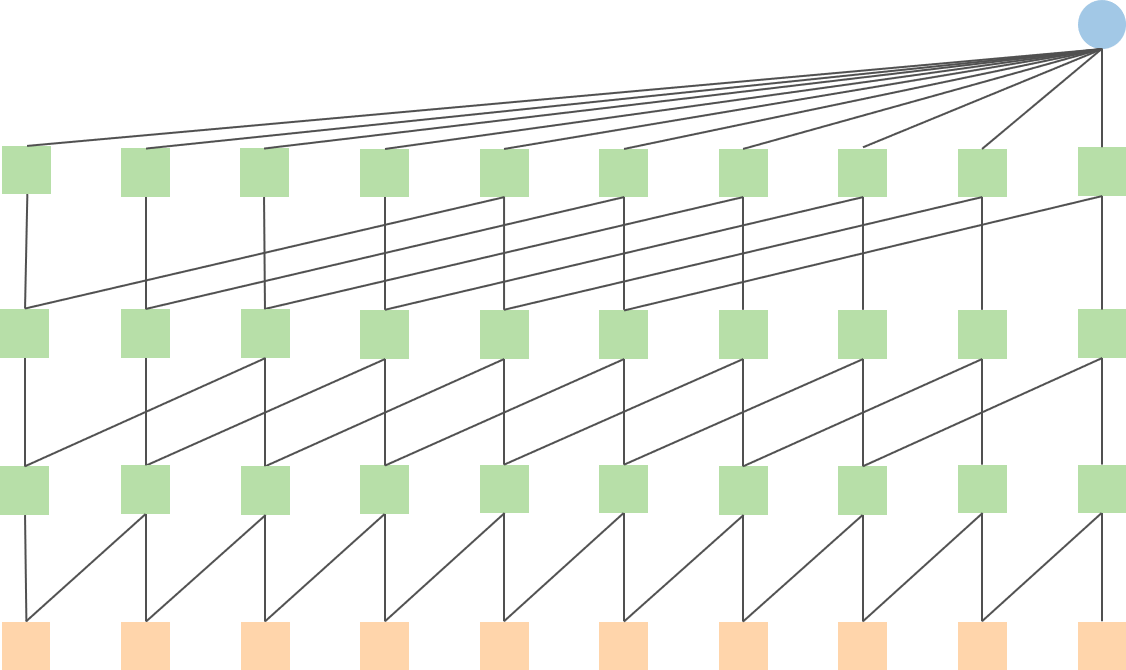


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

Now create a sequential model with 1D convnet. Look at the dilation_rate parameter

In [ ]:
model = #
model.add(#)
model.add(#)
model.add(#)
model.add(#)
model.add(#)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [ ]:
###

# Early stopping trick

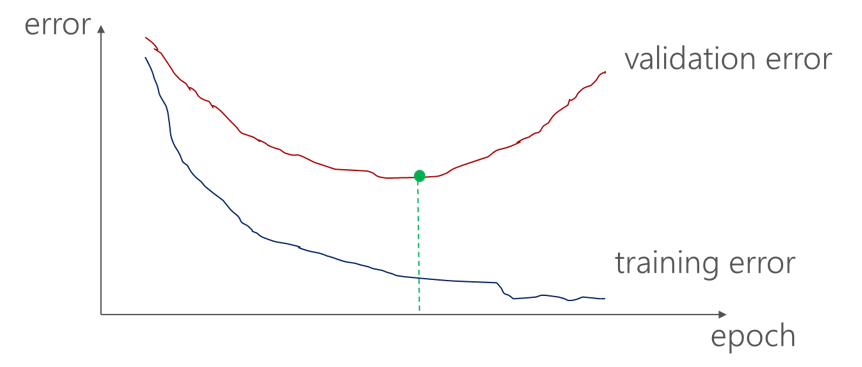

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [ ]:
earlystop = #

In [ ]:
best_val = #

In [ ]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
731/731 [==============================] - 2s 2ms/step - loss: 0.0213 - val_loss: 0.0022
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 9.4874e-04
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 8.8243e-04 - val_loss: 5.7477e-04
Epoch 4/10
731/731 [==============================] - 2s 2ms/step - loss: 6.6573e-04 - val_loss: 4.4434e-04
Epoch 5/10
731/731 [==============================] - 1s 2ms/step - loss: 5.7762e-04 - val_loss: 3.9928e-04
Epoch 6/10
731/731 [==============================] - 1s 2ms/step - loss: 5.0266e-04 - val_loss: 3.3927e-04
Epoch 7/10
731/731 [==============================] - 1s 2ms/step - loss: 4.6420e-04 - val_loss: 3.2248e-04
Epoch 8/10
731/731 [==============================] - 2s 2ms/step - loss: 4.2405e-04 - val_loss: 3.0310e-04
Epoch 9/10
731/731 [==============================] - 1s 2ms/step - loss: 3.9984e-04 - val_loss: 4.1014e-04
Epoch 10/10
731/731 [===================

Load the model with the smallest mape

In [ ]:
best_epoch = #
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

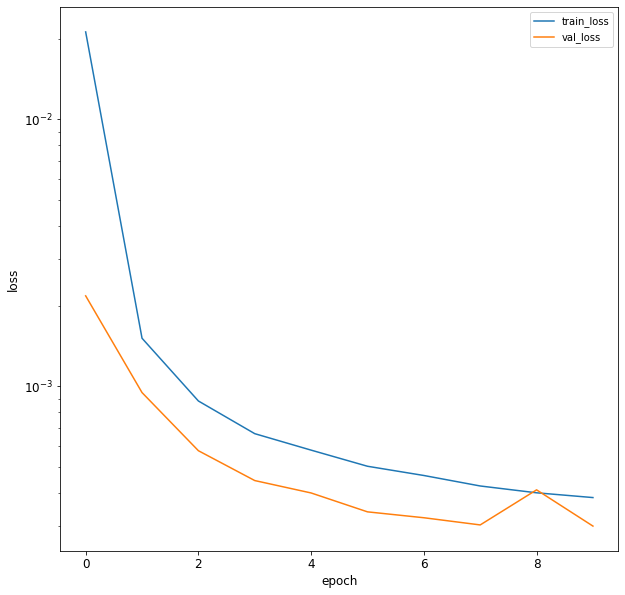

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# Evaluate the model

Create the test set

In [ ]:
look_back_dt = #
test = #
test.head()

load
2014-11-01 00:00:00 2,514.00
2014-11-01 01:00:00 2,434.00
2014-11-01 02:00:00 2,390.00
2014-11-01 03:00:00 2,382.00
2014-11-01 04:00:00 2,419.00

Scale the data

In [ ]:
test['load'] = #
test.head()

load
2014-11-01 00:00:00  0.16
2014-11-01 01:00:00  0.14
2014-11-01 02:00:00  0.13
2014-11-01 03:00:00  0.12
2014-11-01 04:00:00  0.14

Create test set features

In [ ]:
test_shifted = #
test_shifted['y_t+1'] = #
#Loop as before
#
#
test_shifted = #
y_test = #
X_test = #
X_test = #

Make predictions on test set

In [ ]:
predictions = model.predict(X_test)
predictions

array([[0.44],
       [0.47],
       [0.45],
       ...,
       [0.51],
       [0.45],
       [0.41]], dtype=float32)

Compare predictions to actual load

In [ ]:
eval_df = #
eval_df['timestamp'] = #
eval_df = #
eval_df['actual'] = #
eval_df[['prediction', 'actual']] = #
eval_df.head()

timestamp    h  prediction   actual
0 2014-11-01 09:00:00  t+1    3,408.68 3,436.00
1 2014-11-01 10:00:00  t+1    3,490.29 3,464.00
2 2014-11-01 11:00:00  t+1    3,433.32 3,439.00
3 2014-11-01 12:00:00  t+1    3,399.54 3,407.00
4 2014-11-01 13:00:00  t+1    3,397.47 3,389.00

Compute the mean absolute percentage error over all predictions

In [ ]:
#

0.013353020689482843

Plot the predictions vs the actuals for the first week of the test set

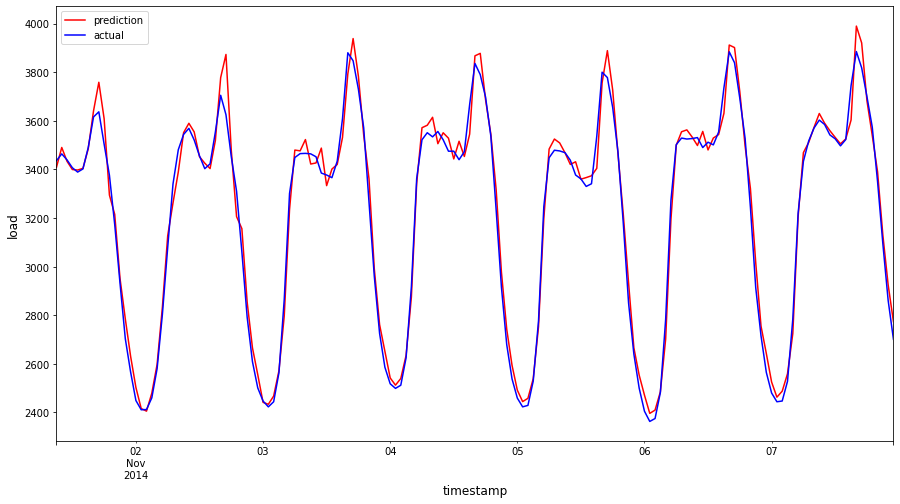

In [ ]:
#Some code goes here

In [ ]:
# clean up model files


for m in glob('model_*.h5'):
    os.remove(m)

